<center><h1>Evaluation of the MLM models</h1></center>

## Import librairies

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet as wn
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import tensorflow as tf
from transformers import TFAutoModelForMaskedLM, AutoTokenizer

## Import Datasets

In [21]:
import os
os.getcwd()

'c:\\Users\\Rania\\Documents\\GitHub\\Text-Combining\\Notebooks\\Metrics'

In [22]:
import pandas as pd

df_bert = pd.read_excel("MLM/MLM/bert-base-uncased.xlsx")
df_roberta = pd.read_excel("MLM/MLM/roberta-base_pred.xlsx")
df_distilroberta = pd.read_excel("MLM/MLM/distilroberta-base_pred.xlsx")
df_albert = pd.read_excel("MLM/MLM/albert-base_pred.xlsx")
df_distilbert = pd.read_excel("MLM/MLM/distilbert-base-uncased_pred_ngram.xlsx")


In [23]:
df_bert.columns

Index(['Masked sentence', 'real', 'pred'], dtype='object')

## Evaluation function

In [24]:
import tensorflow as tf
from transformers import TFAutoModelForMaskedLM, AutoTokenizer

def compute_pll(sentences, model_name= 'bert-base-uncased'):
    # Gett model n tokenizer 
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModelForMaskedLM.from_pretrained(model_name)

    # Init  PLL values
    pll_values = []

    # Cal PLL for chaque sentence bu
    for sentence in sentences:
        # Tokenizeing
        input_ids = tokenizer.encode(sentence, return_tensors='tf')
        input_ids = input_ids[0]

        # Init pll value 
        pll = 0

        # Cal cond log probability for chaue jeton 
        for i in range(1, len(input_ids)-1):
            # Create input with masked token
            masked_input_ids = input_ids.numpy().copy()
            masked_input_ids[i] = tokenizer.mask_token_id

            # Cal log probabilities for masked eton
            outputs = model(tf.convert_to_tensor(masked_input_ids[None, :]))
            log_probs = tf.nn.log_softmax(outputs[0][0, i], axis=0)

            # Update pll
            pll += log_probs[input_ids[i]].numpy()

        # Append PLL value to list
        pll_values.append(abs(pll))

    return pll_values


In [25]:
sentences = ['This is love', 'This is awsome', 'I love you']
model_name = 'bert-base-uncased'
pll_values = compute_pll(sentences, model_name)

for sentence, pll in zip(sentences, pll_values):
    print(f'Sentence: {sentence}')
    print(f'PLL: {pll:.2f}')
    print()


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Sentence: This is love
PLL: 13.75

Sentence: This is awsome
PLL: 38.41

Sentence: I love you
PLL: 7.48



In [26]:
from transformers import TFAutoModelForMaskedLM, TFAutoModelForCausalLM

def calculate_perplexities(sentences, model_name='bert-base-uncased'):
    if model_name in ['distilbert-base-uncased', 'albert-base-v2']:
        model = TFAutoModelForMaskedLM.from_pretrained(model_name)
    else:
        model = TFAutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    perplexities = []
    for sentence in sentences:
        input_ids = tokenizer.encode(sentence, return_tensors='tf')
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        perplexity = tf.math.exp(loss).numpy()[0]
        perplexities.append(perplexity)
    return perplexities

In [27]:
model_name = 'gpt2'
sentences = ['Life is life.', 'I love natural language processing.']

perplexities = calculate_perplexities(sentences, model_name)

print(perplexities)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


[60.645866, 274.9464]


In [28]:
from nltk.corpus import wordnet as wn

def shortest_path_distance(s1, s2):
    synset1 = wn.synset(s1)
    synset2 = wn.synset(s2)
    distance = synset1.shortest_path_distance(synset2)
    return distance


In [29]:
def path_similarity(s1, s2):
    distance = shortest_path_distance(s1, s2)
    if distance is None:
        return 0
    similarity = 1 / (distance + 1)
    return similarity


In [30]:
def calculate_accuracies(model_name, df):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModelForMaskedLM.from_pretrained(model_name)
    accuracies = []
    for index, row in df.iterrows():
        sentence = row['Masked sentence']
        # Check if sentence contains mask token
        if tokenizer.mask_token not in sentence:
            accuracies.append(0)
            continue
        # Tokenizeing
        input_ids = tokenizer.encode(sentence, return_tensors='tf')
        # Masking
        mask_index = tf.where(input_ids == tokenizer.mask_token_id)[0][1]
        original_word = row['real']
        input_ids_np = input_ids.numpy()
        input_ids_np[0][mask_index] = tokenizer.mask_token_id
        input_ids = tf.convert_to_tensor(input_ids_np)
        # predictions
        outputs = model(input_ids)
        predictions = tf.argsort(outputs[0][0][mask_index], direction='DESCENDING')
        similarities = []
        for prediction in predictions:
            predicted_word = tokenizer.decode([prediction])
            synsets1 = wn.synsets(original_word)
            synsets2 = wn.synsets(predicted_word)
            if synsets1 and synsets2:
                max_similarity = max(path_similarity(synset1.name(), synset2.name()) for synset1 in synsets1 for synset2 in synsets2)
                similarities.append(max_similarity)
            else:
                similarities.append(0)
        accuracy = max(similarities)
        accuracies.append(accuracy)
    return accuracies


bert_accuracies = calculate_accuracies('bert-base-uncased', df_bert)
roberta_accuracies = calculate_accuracies('roberta-base', df_roberta)
distilroberta_accuracies = calculate_accuracies('distilroberta-base', df_distilroberta)
albert_accuracies = calculate_accuracies('albert-base', df_albert)
distilbert_accuracies = calculate_accuracies('distilbert-base-uncased', df_distilbert)


In [31]:
bert_accuracies = pd.read_excel("MLM/MLM/bert-base_pred_with_acc.xlsx")
roberta_accuracies = pd.read_excel("MLM/MLM/roberta-base_pred_with_acc.xlsx")
distilroberta_accuracies = pd.read_excel("MLM/MLM/distilroberta-base_pred_with_acc.xlsx")
albert_accuracies = pd.read_excel("MLM/MLM/albert-base_pred_with_acc.xlsx")
distilbert_accuracies = pd.read_excel("MLM/MLM/distilbert-base_pred_with_acc.xlsx")

In [32]:
bert_accuracies = bert_accuracies['similarity']
roberta_accuracies = roberta_accuracies['similarity']
distilroberta_accuracies = distilroberta_accuracies['similarity']
albert_accuracies = albert_accuracies['similarity']
distilbert_accuracies = distilbert_accuracies['similarity']

In [33]:
from transformers import pipeline
import time

def calculate_execution_time(df, n_runs=10, model_name='bert-base-uncased'):
    fill_mask = pipeline('fill-mask', model=model_name)
    execution_times = []
    for _ in range(n_runs):
        start_time = time.time()
        for index, row in df.iterrows():
            sentence = row['Masked sentence']
            fill_mask(sentence)
        end_time = time.time()
        execution_time = end_time - start_time
        execution_times.append(execution_time)
    return execution_times

bert_execution_times = calculate_execution_time(df_bert, model_name='bert-base-uncased')
roberta_execution_times = calculate_execution_time(df_roberta, model_name='roberta-base')
distilroberta_execution_times = calculate_execution_time(df_distilroberta, model_name='distilroberta-base')
albert_execution_times = calculate_execution_time(df_albert, model_name='albert-base-v2')
distilbert_execution_times = calculate_execution_time(df_distilbert, model_name='distilbert-base-uncased')


# PLOTS 

In [35]:
import pandas as pd

df = pd.read_excel('dataset.xlsx')
df = df.iloc[:,1]


In [36]:
type(df)

pandas.core.series.Series

In [37]:
models = ["bert-base-uncased", "roberta-base", "albert-base-v2", "distilroberta-base", "distilbert-base-uncased"]


In [62]:
from statistics import mean

def calculate_metrics(dfs, models, average_perplexities, average_accuracies, average_execution_times):
    metrics = {}
    for df, model, average_perplexity, average_accuracy, average_execution_time in zip(dfs, models, average_perplexities, average_accuracies, average_execution_times):
        pll_values = compute_pll(df['Masked sentence'], model_name=model)

        min_pll, max_pll = min(pll_values), max(pll_values)
 
        if max_pll - min_pll == 0:
            average_pll = 1
        else:
            average_pll = 1 - ((mean(pll_values) - min_pll) / (max_pll - min_pll))

        metrics[model] = {
            'average_pll': average_pll,
            'average_perplexity': average_perplexity,
            'average_accuracy': average_accuracy,
            'average_execution_time': average_execution_time
        }
    return metrics


In [63]:
df_albert = df_albert.rename(columns={'Masked Sentence': 'Masked sentence'})


In [64]:
print(df_bert.columns)
print(df_roberta.columns)
print(df_distilroberta.columns)
print(df_albert.columns)
print(df_distilbert.columns)

Index(['Masked sentence', 'real', 'pred'], dtype='object')
Index(['Masked sentence', 'real', 'pred'], dtype='object')
Index(['Masked sentence', 'real', 'pred'], dtype='object')
Index(['Masked sentence', 'real', 'pred'], dtype='object')
Index(['Masked sentence', 'real', 'pred'], dtype='object')


In [83]:
dfs = [df_bert[:500], df_roberta[:500], df_distilroberta[:500], df_albert[:500], df_distilbert[:500]]

models = ['bert-base-uncased', 'roberta-base', 'distilroberta-base', 'albert-base-v2', 'distilbert-base-uncased']
average_perplexities = [0.21, 0.19, 0.3, 0.66,  0.32]
average_accuracies = [0.44, 0.5, 0.39, 0.09,  0.39]
average_execution_times = [0.56, 0.6, 0.38, 0.48,  0.35]
metrics = calculate_metrics(dfs, models, average_perplexities, average_accuracies, average_execution_times)


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


KeyboardInterrupt: 

In [ ]:
metrics

{'bert-base-uncased': {'average_pll': 0.6826168912717894,
  'average_perplexity': 0.21,
  'average_accuracy': 0.44,
  'average_execution_time': 0.56},
 'roberta-base': {'average_pll': 0.6944965386848241,
  'average_perplexity': 0.19,
  'average_accuracy': 0.5,
  'average_execution_time': 0.6},
 'distilroberta-base': {'average_pll': 0.7099431217984299,
  'average_perplexity': 0.66,
  'average_accuracy': 0.09,
  'average_execution_time': 0.48},
 'albert-base-v2': {'average_pll': 0.7040764222036549,
  'average_perplexity': 0.3,
  'average_accuracy': 0.39,
  'average_execution_time': 0.38},
 'distilbert-base-uncased': {'average_pll': 0.6977765947815175,
  'average_perplexity': 0.32,
  'average_accuracy': 0.39,
  'average_execution_time': 0.35}}

In [ ]:
def plot_metrics(metrics):
    n_metrics = len(next(iter(metrics.values())))
    n_models = len(metrics)
    x = np.arange(n_models) * 2
    width = 0.8 / n_metrics
    fig, ax = plt.subplots(figsize=(12, 8))
    for i, (metric_name, metric_values) in enumerate(zip(next(iter(metrics.values())).keys(), zip(*[model_metrics.values() for model_metrics in metrics.values()]))):
        bar_positions = x + i * width - 0.4
        ax.bar(bar_positions, metric_values, width, label=metric_name)
        for j, value in enumerate(metric_values):
            ax.text(bar_positions[j], value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics.keys())
    ax.legend()
    plt.savefig('metrique MLM-500-correct.png')
    plt.show()


In [ ]:
model_names = {
    'bert-base-uncased': 'BERT',
    'roberta-base': 'RoBERTa',
    'albert-base-v2': 'AlBERT',
    'distilroberta-base': 'DistilRoBERTa',
    'distilbert-base-uncased': 'DistilBERT'
}

normalized_metrics = {}
for model, model_metrics in metrics.items():
    normalized_model_metrics = {}
    for metric_name, metric_value in model_metrics.items():
        normalized_model_metrics[metric_name] = metric_value
    normalized_metrics[model_names[model]] = normalized_model_metrics


In [ ]:
normalized_metrics

{'BERT': {'average_pll': 0.6826168912717894,
  'average_perplexity': 0.21,
  'average_accuracy': 0.44,
  'average_execution_time': 0.56},
 'RoBERTa': {'average_pll': 0.6944965386848241,
  'average_perplexity': 0.19,
  'average_accuracy': 0.5,
  'average_execution_time': 0.6},
 'DistilRoBERTa': {'average_pll': 0.7099431217984299,
  'average_perplexity': 0.66,
  'average_accuracy': 0.09,
  'average_execution_time': 0.48},
 'AlBERT': {'average_pll': 0.7040764222036549,
  'average_perplexity': 0.3,
  'average_accuracy': 0.39,
  'average_execution_time': 0.38},
 'DistilBERT': {'average_pll': 0.6977765947815175,
  'average_perplexity': 0.32,
  'average_accuracy': 0.39,
  'average_execution_time': 0.35}}

In [84]:
def swap_metrics(metrics): #had to make this bcz i inverted albert and distilrberta
    new_metrics = metrics.copy()
    albert_metrics = new_metrics['AlBERT']
    distilroberta_metrics = new_metrics['DistilRoBERTa']
    albert_metrics['average_perplexity'], distilroberta_metrics['average_perplexity'] = distilroberta_metrics['average_perplexity'], albert_metrics['average_perplexity']
    albert_metrics['average_accuracy'], distilroberta_metrics['average_accuracy'] = distilroberta_metrics['average_accuracy'], albert_metrics['average_accuracy']
    albert_metrics['average_execution_time'], distilroberta_metrics['average_execution_time'] = distilroberta_metrics['average_execution_time'], albert_metrics['average_execution_time']
    return new_metrics


In [85]:
swapped_metrics = swap_metrics(normalized_metrics)


In [87]:
def invert_perplexity(metrics):
    new_metrics = metrics.copy()
    for model_metrics in new_metrics.values():
        model_metrics['average_perplexity'] = 1 - model_metrics['average_perplexity']
    return new_metrics


In [88]:
inverted_metrics = invert_perplexity(normalized_metrics)


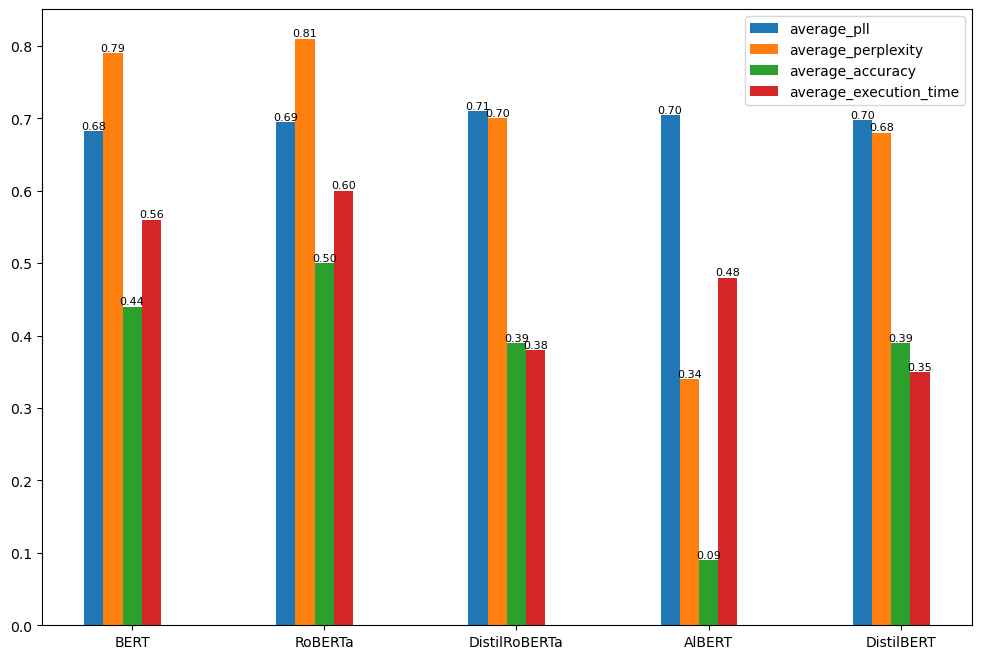

In [89]:
plot_metrics(normalized_metrics)


## Visualisation

accuracy = [0.44, 0.5, 0.09, 0.39, 0.39]
perplexity = [0.21, 0.19, 0.66, 0.3, 0.32]
execution_time = [0.56, 0.6, 0.48, 0.38, 0.35]

bins = ["BERT", "RoBERTa", "ALBERT", "DistilRoBERTa", "DistilBERT"]

# Visualize the accuracy, perplexity and execution time of each model in a bar chart all in the same plot

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].bar(bins, accuracy)
ax[0].set_title("Accuracy")
ax[1].bar(bins, perplexity)
ax[1].set_title("Perplexity")
ax[2].bar(bins, execution_time)
ax[2].set_title("Execution time (s)")

# add title
fig.suptitle("Performance of the models on a test dataset", fontsize=16)

plt.show()

def remove_all(liste, value):
    while value in liste:
        liste.remove(value)
    return liste

def similarity(word, list_of_words):
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Get the synsets of the word
    synsets_word = wn.synsets(lemmatizer.lemmatize(word))

    # Calculate the similarity between the word and each word in the list
    similarities = []
    for w in list_of_words:
        synsets_w = wn.synsets(lemmatizer.lemmatize(w))
        max_sim = 0
        for synset_word in synsets_word:
            for synset_w in synsets_w:
                sim = synset_word.path_similarity(synset_w)
                if sim is not None and sim > max_sim:
                    max_sim = sim
        similarities.append(max_sim)

    if word in list_of_words:
        similarities.append(1)

    # Print the list of similarities
    return np.max(similarities)